In [1]:
%matplotlib inline

In [1]:
import pandas as pd 

import duckdb
from tqdm.auto import tqdm 

In [2]:
df = pd.read_csv('matching_results.csv')

In [3]:
df.head(1000).to_clipboard(index=False, sep='\t')

/Users/raphaelcourivaud/anaconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


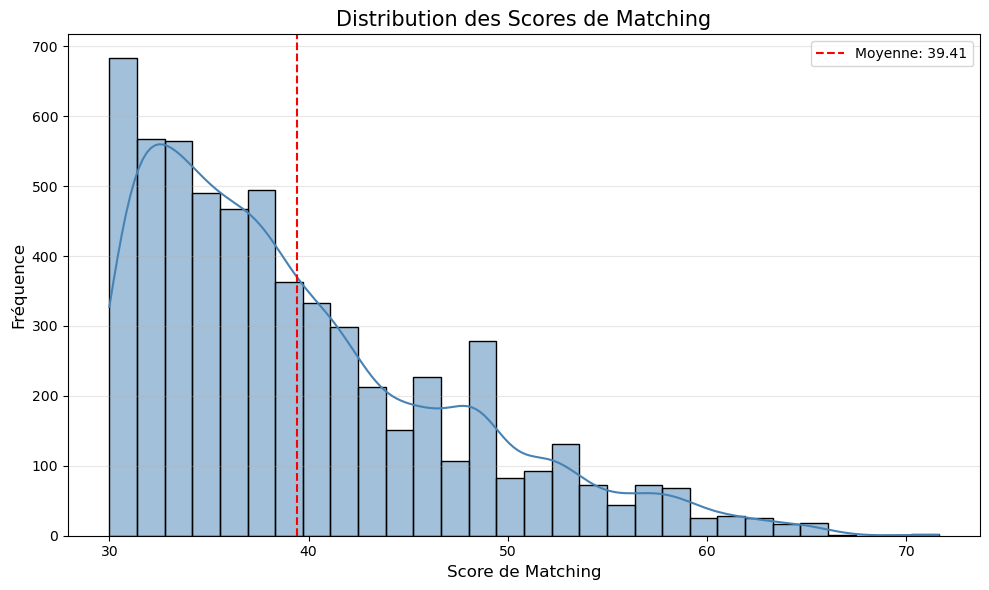

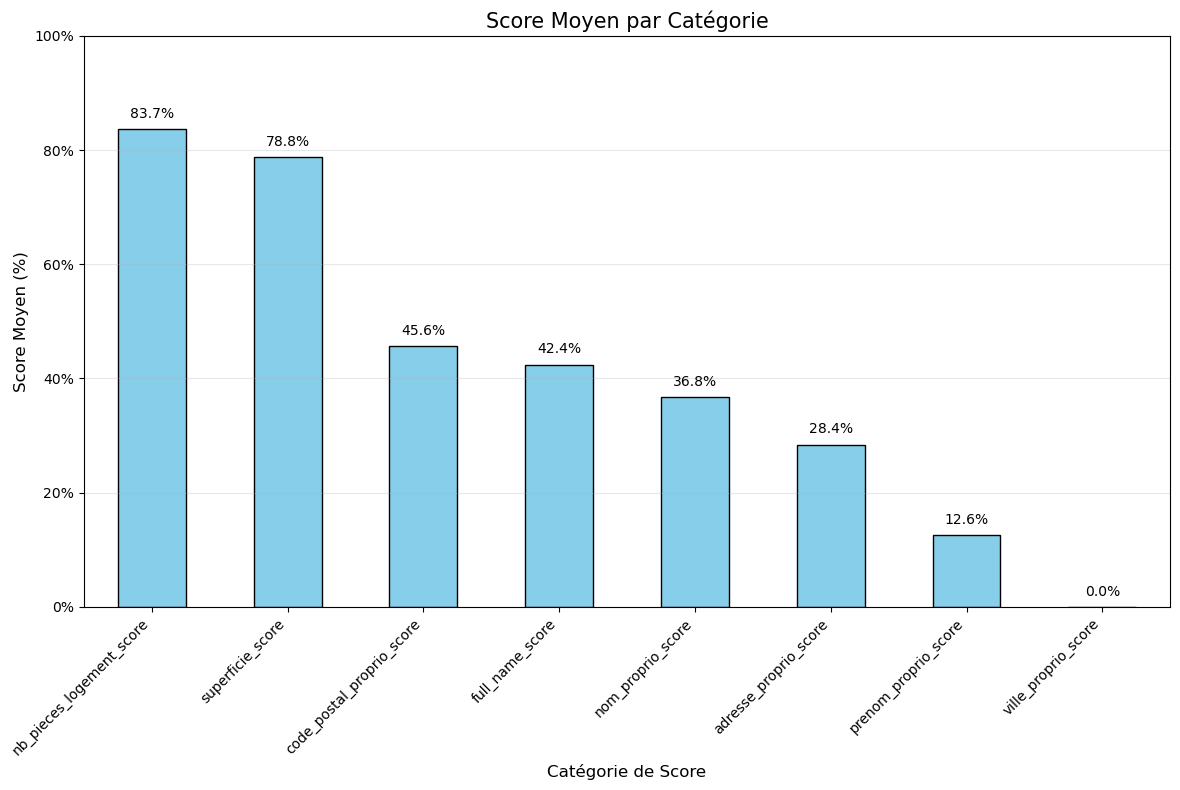

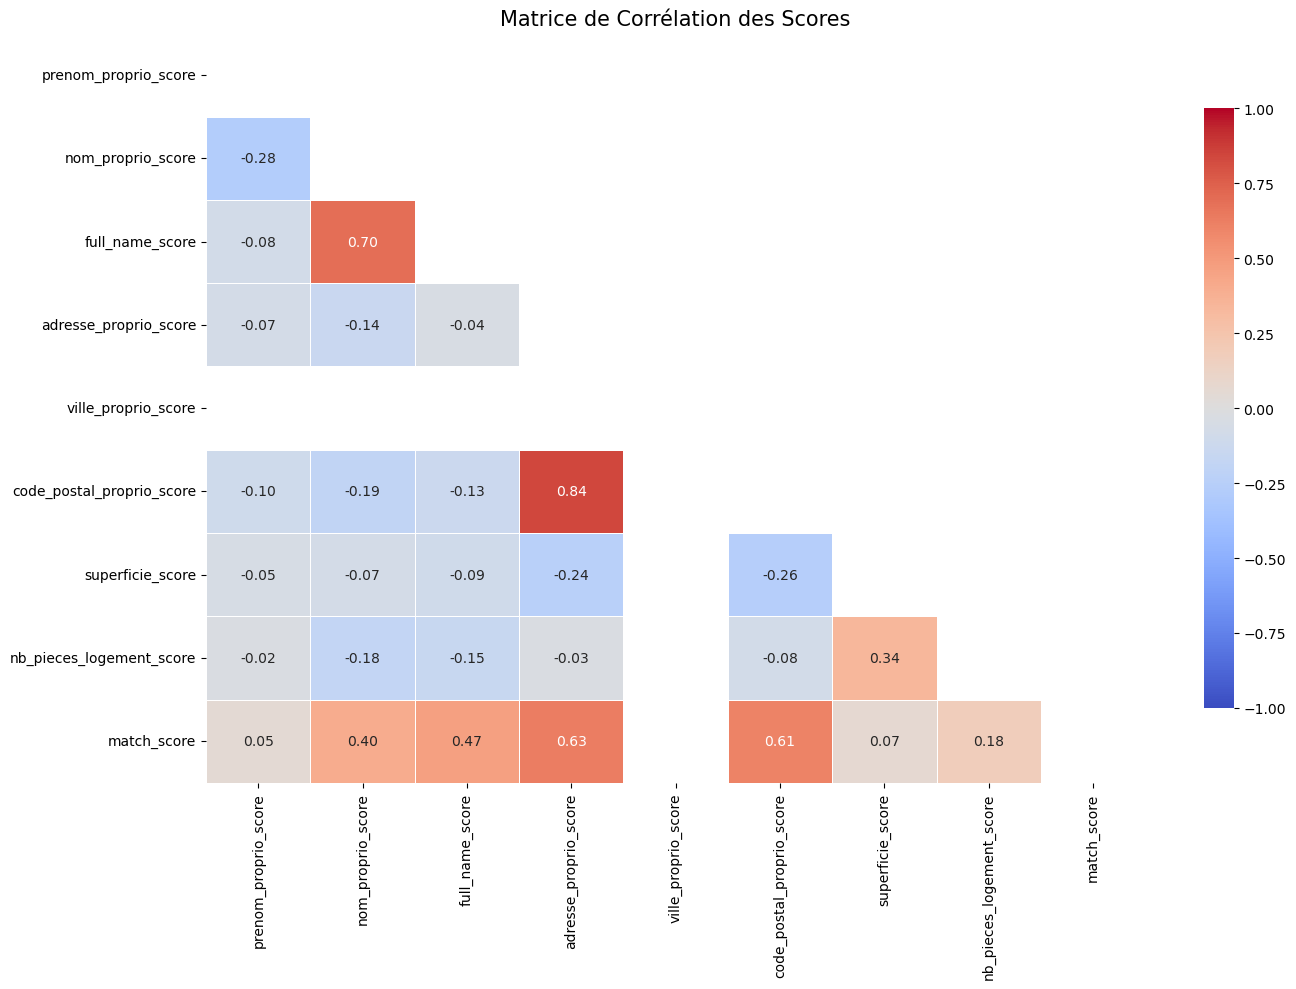

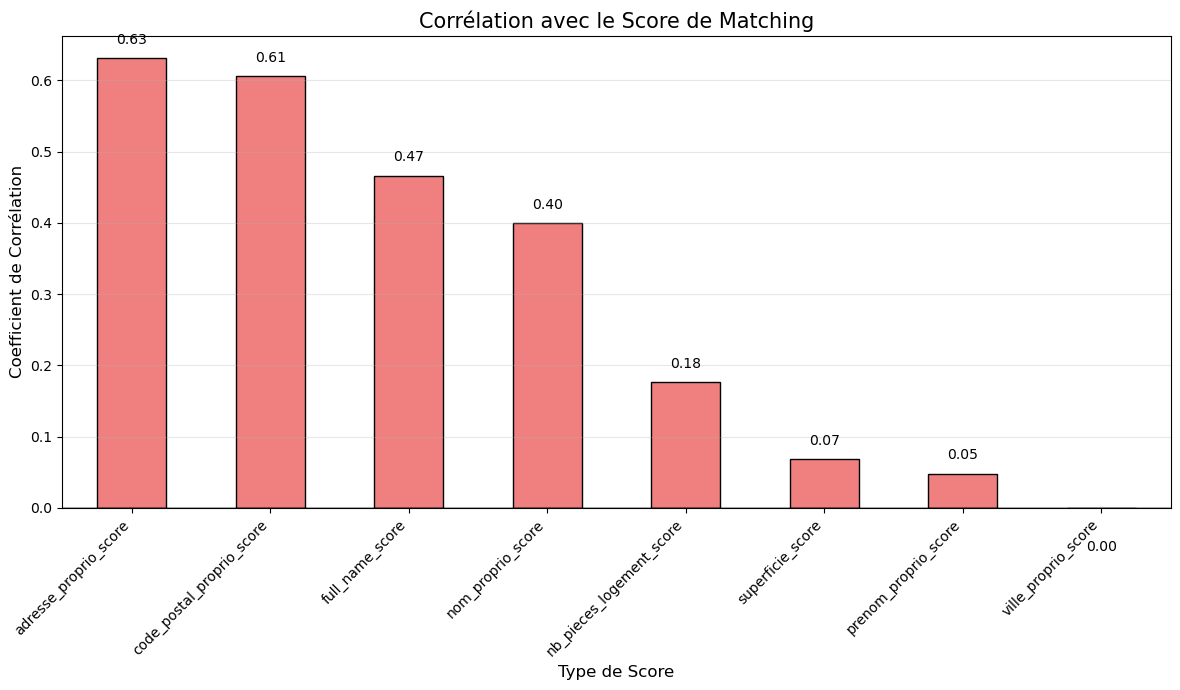

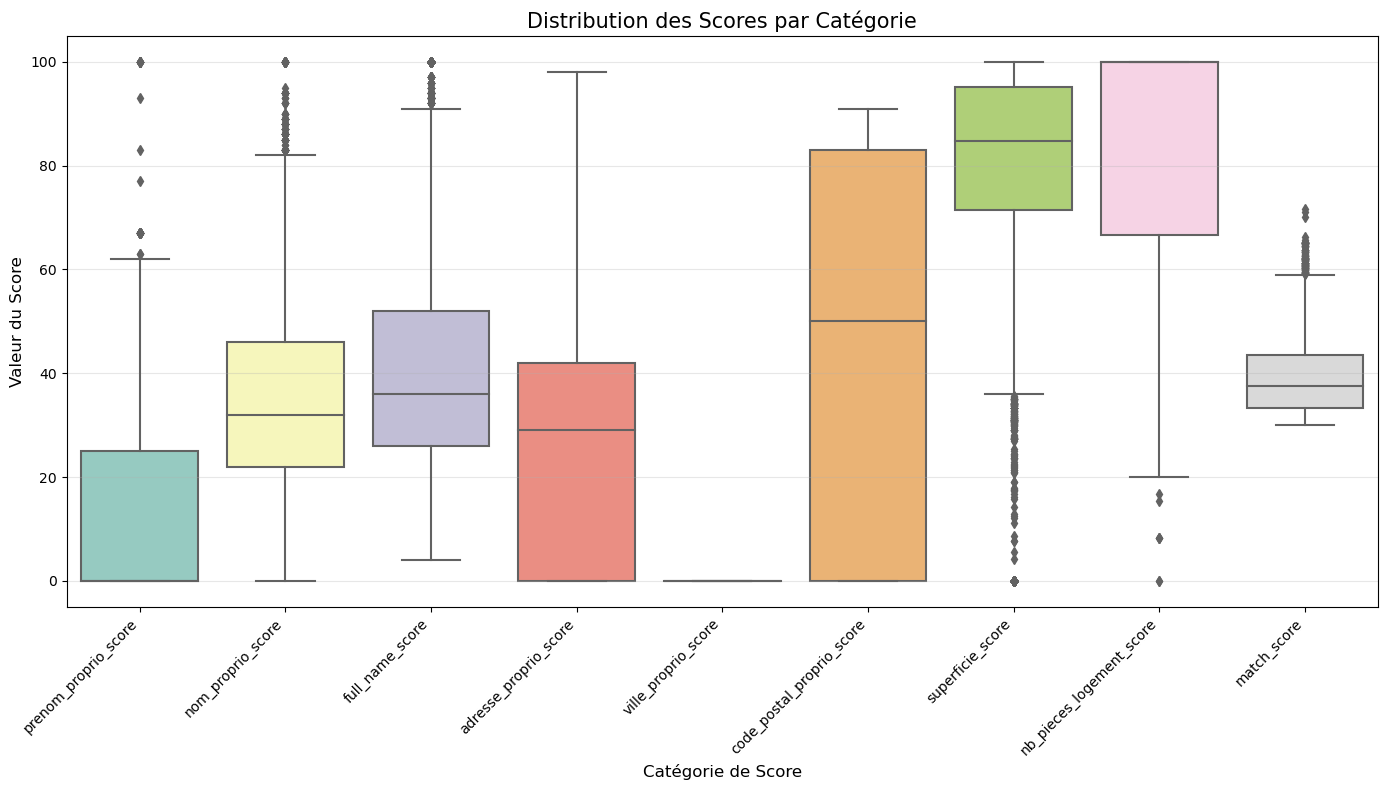

/Users/raphaelcourivaud/anaconda3/envs/py310/lib/python3.10/site-packages/numpy/lib/polynomial.py:668: RuntimeWarning: invalid value encountered in divide
  lhs /= scale


 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  5 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value


LinAlgError: SVD did not converge in Linear Least Squares

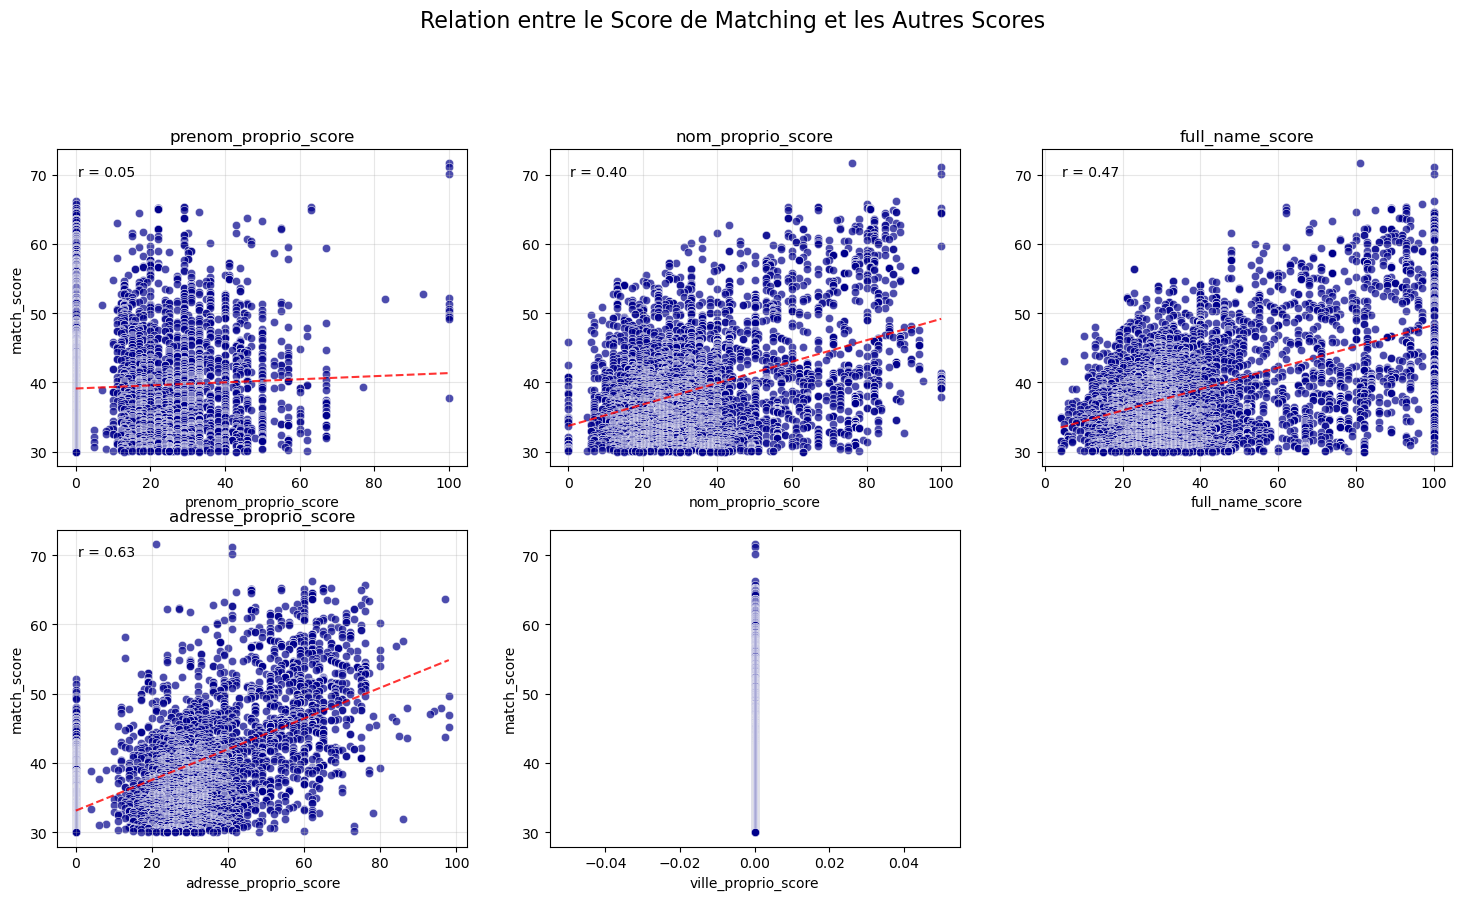

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mtick

# Charger les données
df = pd.read_csv('matching_results.csv')

# Identifier les colonnes de score
score_columns = [col for col in df.columns if col.endswith('_score') and col != 'match_score']

# 1. DISTRIBUTION DU SCORE GLOBAL DE MATCHING
plt.figure(figsize=(10, 6))
sns.histplot(df['match_score'], kde=True, bins=30, color='steelblue')
plt.axvline(df['match_score'].mean(), color='red', linestyle='--', label=f"Moyenne: {df['match_score'].mean():.2f}")
plt.title('Distribution des Scores de Matching', fontsize=15)
plt.xlabel('Score de Matching', fontsize=12)
plt.ylabel('Fréquence', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('matching_score_distribution.png', dpi=300)
plt.show()

# 2. COMPARAISON DES MOYENNES DE SCORES PAR CATÉGORIE
mean_scores = df[score_columns].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
bars = mean_scores.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Score Moyen par Catégorie', fontsize=15)
plt.xlabel('Catégorie de Score', fontsize=12)
plt.ylabel('Score Moyen (%)', fontsize=12)
plt.ylim(0, 100)
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(100))

# Ajouter les valeurs sur les barres
for bar in bars.patches:
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 2,
        f'{bar.get_height():.1f}%',
        ha='center',
        fontsize=10
    )
plt.tight_layout()
plt.savefig('mean_scores_by_category.png', dpi=300)
plt.show()

# 3. MATRICE DE CORRÉLATION
plt.figure(figsize=(14, 10))
corr = df[score_columns + ['match_score']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))  # Masque pour afficher la moitié de la matrice
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, 
            linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Matrice de Corrélation des Scores', fontsize=15)
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300)
plt.show()

# 4. TOP CORRÉLATIONS AVEC LE SCORE DE MATCHING
corr_with_match = corr['match_score'].drop('match_score').sort_values(ascending=False)

plt.figure(figsize=(12, 7))
bars = corr_with_match.plot(kind='bar', color='lightcoral', edgecolor='black')
plt.title('Corrélation avec le Score de Matching', fontsize=15)
plt.xlabel('Type de Score', fontsize=12)
plt.ylabel('Coefficient de Corrélation', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xticks(rotation=45, ha='right')

# Ajouter les valeurs sur les barres
for bar in bars.patches:
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.02 if bar.get_height() > 0 else bar.get_height() - 0.06,
        f'{bar.get_height():.2f}',
        ha='center',
        fontsize=10
    )
plt.tight_layout()
plt.savefig('correlations_with_match_score.png', dpi=300)
plt.show()

# 5. DISTRIBUTION DES SCORES PAR CATÉGORIE (BOXPLOT)
plt.figure(figsize=(14, 8))
df_melted = pd.melt(df, value_vars=score_columns + ['match_score'], var_name='Score Type', value_name='Value')
sns.boxplot(x='Score Type', y='Value', data=df_melted, palette='Set3')
plt.title('Distribution des Scores par Catégorie', fontsize=15)
plt.xlabel('Catégorie de Score', fontsize=12)
plt.ylabel('Valeur du Score', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('score_distributions_boxplot.png', dpi=300)
plt.show()

# 6. SCATTER PLOTS : MATCH_SCORE VS AUTRES SCORES
fig = plt.figure(figsize=(18, 14))
gs = GridSpec(3, 3, figure=fig)
fig.suptitle('Relation entre le Score de Matching et les Autres Scores', fontsize=16, y=0.98)

for i, col in enumerate(score_columns):
    ax = fig.add_subplot(gs[i//3, i%3])
    sns.scatterplot(x=col, y='match_score', data=df, ax=ax, color='darkblue', alpha=0.7)
    
    # Ajouter une ligne de régression
    z = np.polyfit(df[col], df['match_score'], 1)
    p = np.poly1d(z)
    ax.plot(np.sort(df[col]), p(np.sort(df[col])), "r--", alpha=0.8)
    
    ax.text(0.05, 0.95, f"r = {corr[col]['match_score']:.2f}", transform=ax.transAxes, 
            fontsize=10, verticalalignment='top')
    
    ax.set_title(f'{col}', fontsize=12)
    ax.set_xlabel(col, fontsize=10)
    ax.set_ylabel('match_score' if i % 3 == 0 else "", fontsize=10)
    ax.grid(alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('scatter_plots.png', dpi=300)
plt.show()

# 7. CONTRIBUTION RELATIVE DES SCORES
# Calculer et visualiser les rangs des scores
# Pour chaque entrée, ranger les scores du plus haut au plus bas
ranks = df[score_columns].rank(axis=1, ascending=False)
avg_ranks = ranks.mean().sort_values()

plt.figure(figsize=(10, 6))
avg_ranks.plot(kind='barh', color='lightgreen', edgecolor='black')
plt.title('Rang Moyen des Scores (Plus bas = Plus important)', fontsize=15)
plt.xlabel('Rang Moyen', fontsize=12)
plt.ylabel('Type de Score', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('average_score_ranks.png', dpi=300)
plt.show()

# 8. SEUILS DE SCORE ET POURCENTAGE DE SUCCÈS
thresholds = [50, 55, 60, 65, 70]
success_rates = {}

for thresh in thresholds:
    success_rates[thresh] = (df['match_score'] >= thresh).mean() * 100

plt.figure(figsize=(10, 6))
plt.plot(list(success_rates.keys()), list(success_rates.values()), 'o-', color='purple', linewidth=2, markersize=8)
plt.title('Taux de Succès selon le Seuil de Score', fontsize=15)
plt.xlabel('Seuil de Score', fontsize=12)
plt.ylabel('Pourcentage de Correspondances (%)', fontsize=12)
plt.grid(alpha=0.3)
plt.xticks(thresholds)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

for x, y in success_rates.items():
    plt.text(x, y+2, f'{y:.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('success_rates_by_threshold.png', dpi=300)
plt.show()

# 9. ANALYSE DE LA VARIATION DU SCORE DE MATCHING PAR CATÉGORIE
# Cette analyse peut aider à comprendre la variance expliquée

df_z = df[score_columns].apply(lambda x: (x - x.mean()) / x.std())
df_z['match_score'] = df['match_score']

plt.figure(figsize=(12, 8))
for col in score_columns:
    plt.scatter(df_z[col], df_z['match_score'], alpha=0.6, label=col)

plt.title('Influence des Scores Standardisés sur le Score de Matching', fontsize=15)
plt.xlabel('Score Standardisé (Z-Score)', fontsize=12)
plt.ylabel('Score de Matching (Z-Score)', fontsize=12)
plt.grid(alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('standardized_scores_influence.png', dpi=300)
plt.show()